In [1]:
%matplotlib notebook

In [2]:
import math
import cmath
import IPython
from os import fsencode
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk, find_peaks, buttord, butter, iirnotch
import soundfile as sf

Pocet vzorku signalu: 33485 [Vzorku]
Delka signalu: 2.0928125 [s]
Max: 2821
Min: -2276


<IPython.core.display.Javascript object>


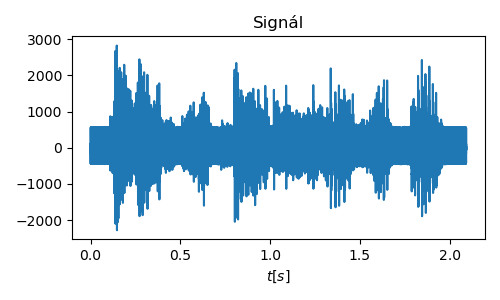

In [3]:
fs, s = wavfile.read("../audio/xkravc02.wav")
print ("Pocet vzorku signalu:", s.size,"[Vzorku]")
s_t = np.arange(s.size) / fs
print ("Delka signalu:", s.size/fs,"[s]")
print ("Max:", s.max())
print ("Min:", s.min())

plt.figure(figsize=(5,3))
plt.plot(s_t, s)
plt.gca().set_xlabel('$t[s]$')
plt.title('Signál')
plt.tight_layout()
IPython.display.display(IPython.display.Audio(s, rate=fs))

<IPython.core.display.Javascript object>


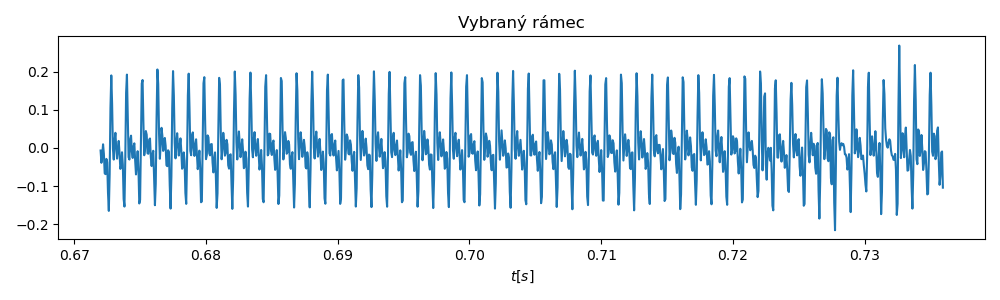

In [4]:
mid = np.mean(s)
s = s - mid
s /= np.abs(s).max() 

start = 0  
seg_len = 1024/fs 
shift = 512/fs 

length = int(((s_t[-1]*fs)/512)-1)
segArray = [] 

for i in range(length):     
    seg_start_s = int(start * fs)               
    seg_len_s = int((start + seg_len) * fs)     

    segment = s[seg_start_s:seg_len_s]
    
    start = start + shift
    segArray.append(segment)
    
segment_t = ((np.arange(segArray[21].size) / fs) + 21*512/fs)
plt.figure(figsize=(10,3))
plt.plot(segment_t, segArray[21])
plt.gca().set_xlabel('$t[s]$')
plt.title('Vybraný rámec')
plt.tight_layout()

<IPython.core.display.Javascript object>


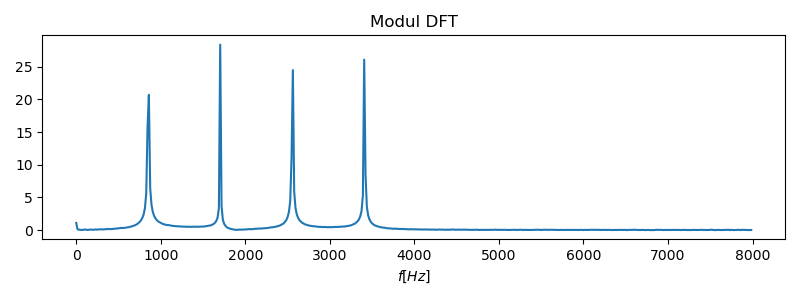

In [5]:
def dft_func(frames):
    res = []
    N=1024
    for tmp in frames:
        my_dft = []
        for k in range(1024):
            dft = 0
            step = 0
            for i in range(31):
                dft = tmp[i] * cmath.exp(-(cmath.pi*2j*k*i/N))
                step = step + dft
            my_dft.append(step)
        res.append(np.array(my_dft))
    return res

dft_lib = np.fft.fft(segArray[1])

mydft = dft_func(segArray)

f = np.arange(dft_lib.size)/dft_lib.size*fs
plt.figure(figsize=(8,3))
plt.plot(f[:f.size//2], np.abs(dft_lib[:dft_lib.size//2]))
plt.gca().set_xlabel('$f[Hz]$')
plt.gca().set_title('Modul DFT')
plt.tight_layout()

<IPython.core.display.Javascript object>


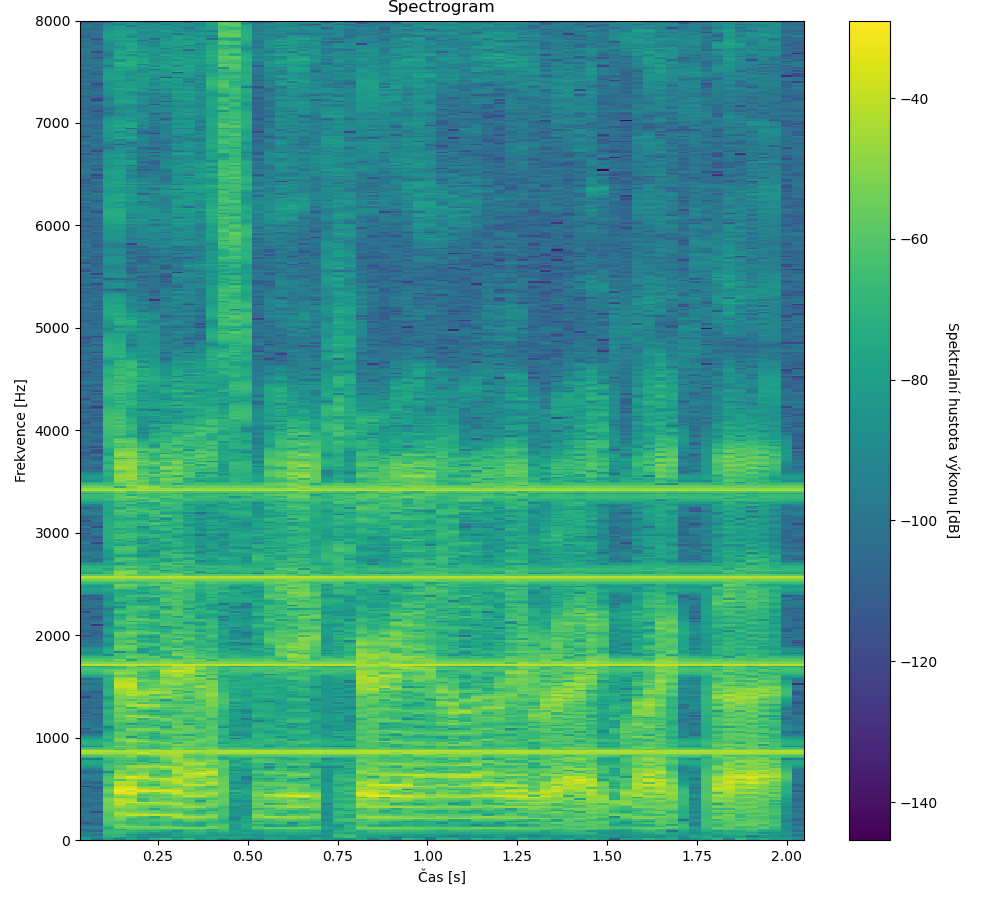

<ipython-input-6-099b4eaeeb9b>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,s_log)


Text(0.5, 1.0, 'Spectrogram')

In [6]:
f, t, sgr = spectrogram(s, fs, nperseg=1024, noverlap=512)
s_log = 10 * np.log10(sgr+1e-20) 
plt.figure(figsize=(10,9))
plt.pcolormesh(t,f,s_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()
plt.title('Spectrogram')


In [7]:
freq1 = 852.5
freq2 = freq1 + freq1
freq3 = freq2 + freq1
freq4 = freq3 + freq1

<IPython.core.display.Javascript object>


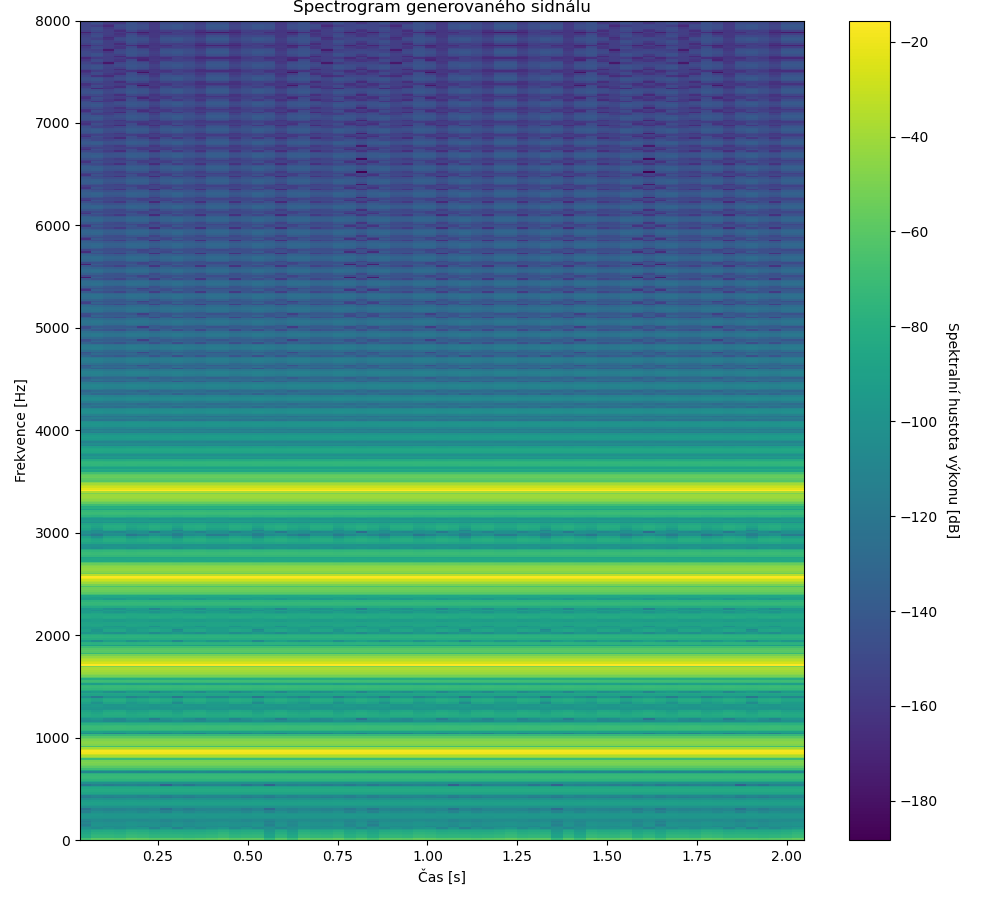

<ipython-input-8-1c5398bb6575>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,sgr_log)


In [8]:
samples = []
for i in range(s.size):
    samples.append(i*1/fs)
cos1 = np.cos(np.array(samples) * 2 * np.pi * freq1)
cos2 = np.cos(np.array(samples) * 2 * np.pi * freq2)
cos3 = np.cos(np.array(samples) * 2 * np.pi * freq3)
cos4 = np.cos(np.array(samples) * 2 * np.pi * freq4)
cos = cos1 + cos2 + cos3 + cos4
sf.write("../audio/4cos.wav", cos, fs)
f, t, sgr = spectrogram(cos, fs, nperseg=1024, noverlap=512)
sgr_log = 10 * np.log10(sgr+1e-20) 
plt.figure(figsize=(10,9))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()
plt.title('Spectrogram generovaného sidnálu')
IPython.display.display(IPython.display.Audio(cos, rate=fs))

<IPython.core.display.Javascript object>


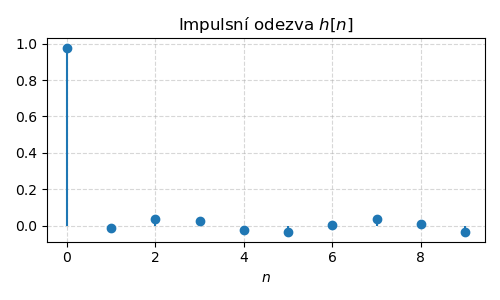

In [9]:
konst = 30.0
c, d = iirnotch(freq1, konst, fs)
freq1, h1 = freqz(c, d, 2048)
filter1 = 10 * np.log10(abs(h1+1e-20))
filtered = lfilter(c, d, s)
c, d = iirnotch(freq2, konst, fs)
freq2, h2 = freqz(c, d, 2048)
filter2 = 10 * np.log10(abs(h2+1e-20))
filtered = lfilter(c, d, filtered)
c, d = iirnotch(freq3, konst, fs)
freq3, h3 = freqz(c, d, 2048)
filter3 = 10 * np.log10(abs(h3+1e-20))
filtered = lfilter(c, d, filtered)
c, d = iirnotch(freq4, konst, fs)
freq4, h4 = freqz(c, d, 2048)
filter4 = 10 * np.log10(abs(h4+1e-20))
filtered = lfilter(c, d, filtered)
impls = [1, *np.zeros(9)]
h = lfilter(c, d, impls)

plt.figure(figsize=(5,3))
plt.stem(np.arange(10), h, basefmt=' ')
plt.gca().set_xlabel('$n$')
plt.title('Impulsní odezva $h[n]$')
plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()   

<IPython.core.display.Javascript object>


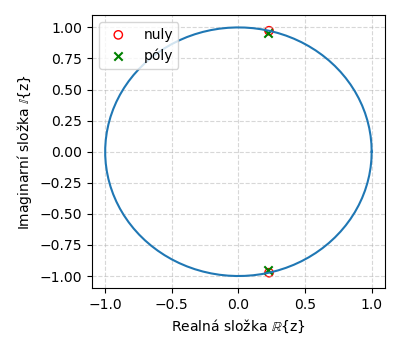

In [10]:
zero, pole, k = tf2zpk(c, d)
plt.figure(figsize=(4,3.5))

aaa = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(aaa), np.sin(aaa))

plt.scatter(np.real(zero), np.imag(zero), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(pole), np.imag(pole), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()


<IPython.core.display.Javascript object>


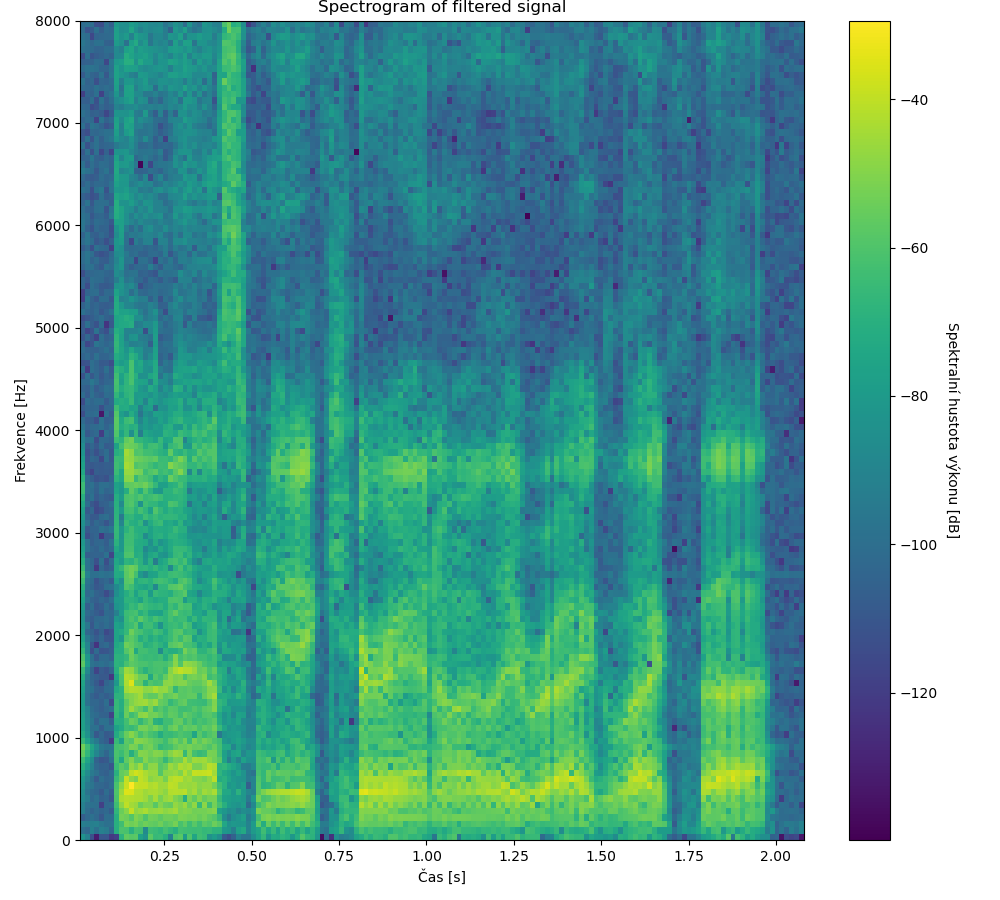

<ipython-input-11-8f3e1603afb5>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,f_sptgr_log)


In [11]:
f, t, f_sptgr = spectrogram(filtered, fs)
f_sptgr_log = 10 * np.log10(f_sptgr+1e-20)
plt.figure(figsize=(10,9))
plt.pcolormesh(t,f,f_sptgr_log)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()
plt.title('Spectrogram of filtered signal')
sf.write("../audio/clean_bandstop.wav", filtered, fs)

In [12]:
IPython.display.display(IPython.display.Audio(filtered, rate=fs))
